In [1]:
!pip install datasets sklearn-crfsuite -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 3.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.9 MB/s eta 0:00:0000:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x8

In [2]:
from datasets import load_dataset

# Tải dataset tiếng Việt
dataset = load_dataset("unimelb-nlp/wikiann", "vi")

train_ds = dataset["train"]
val_ds = dataset["validation"]
test_ds = dataset["test"]

def ds_to_sents(ds):
    sents = []
    for tokens, tags in zip(ds["tokens"], ds["ner_tags"]):
        tag_names = [ds.features["ner_tags"].feature.names[t] for t in tags]
        sents.append(list(zip(tokens, tag_names)))
    return sents

train_sents = ds_to_sents(train_ds)
val_sents = ds_to_sents(val_ds)
test_sents = ds_to_sents(test_ds)

README.md: 0.00B [00:00, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/568k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/571k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

## CRF model

In [4]:
def word2features(sent, i):
    word = sent[i][0]
    feats = {
        'bias': 1.0,
        'word.lower': word.lower(),
        'word[-3:]': word[-3:],
        'word.isupper': word.isupper(),
        'word.istitle': word.istitle(),
        'word.isdigit': word.isdigit(),
    }
    if i > 0:
        prev = sent[i-1][0]
        feats.update({
            '-1:word.lower': prev.lower(),
            '-1:word.istitle': prev.istitle(),
        })
    else:
        feats['BOS'] = True

    if i < len(sent)-1:
        nxt = sent[i+1][0]
        feats.update({
            '+1:word.lower': nxt.lower(),
            '+1:word.istitle': nxt.istitle(),
        })
    else:
        feats['EOS'] = True

    return feats

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for _, label in sent]


In [5]:
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_val = [sent2features(s) for s in val_sents]
y_val = [sent2labels(s) for s in val_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

In [6]:
from sklearn_crfsuite import CRF

crf = CRF(algorithm='lbfgs',max_iterations=100,all_possible_transitions=True)


crf.fit(X_train, y_train)


CRF(algorithm='lbfgs', all_possible_transitions=True, max_iterations=100)

Accuracy: 0.8946
              precision    recall  f1-score   support

           O     0.9477    0.9349    0.9413     23398
       B-PER     0.8635    0.8866    0.8749      3738
       I-PER     0.8822    0.8897    0.8859      7650
       B-LOC     0.8520    0.8265    0.8391      3832
       I-LOC     0.9014    0.8560    0.8781      8376
       B-ORG     0.8461    0.7804    0.8120      3621
       I-ORG     0.8437    0.9039    0.8727     13607

    accuracy                         0.8946     64222
   macro avg     0.8767    0.8683    0.8720     64222
weighted avg     0.8955    0.8946    0.8947     64222

F1-score (macro): 0.8720


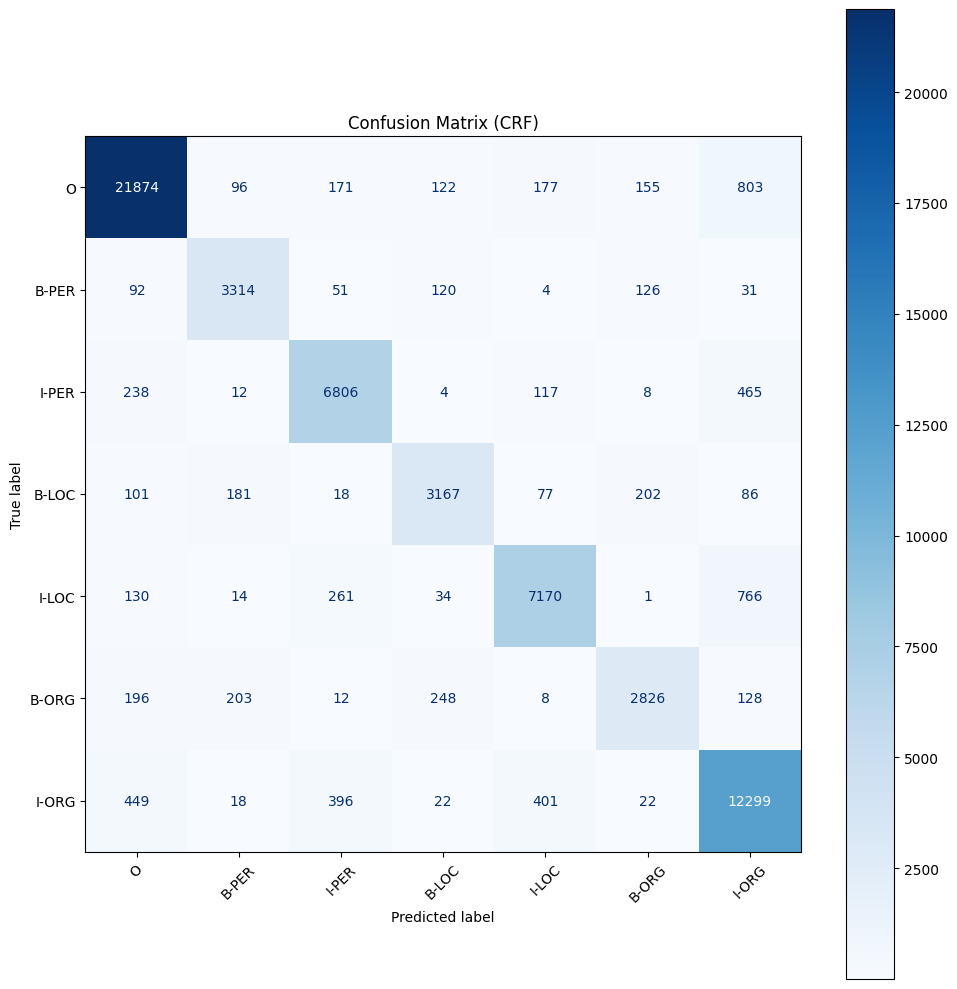

In [8]:
from sklearn_crfsuite import metrics
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


y_pred = crf.predict(X_val)
accuracy = metrics.flat_accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print(metrics.flat_classification_report(
    y_val, y_pred,
    labels=["O","B-PER","I-PER","B-LOC","I-LOC","B-ORG","I-ORG"],
    digits=4
))


# Flatten nhãn (danh sách các list -> 1 list)
y_val_flat = [label for seq in y_val for label in seq]
y_pred_flat = [label for seq in y_pred for label in seq]

f1_macro = f1_score(y_val_flat, y_pred_flat, average="macro")
print(f"F1-score (macro): {f1_macro:.4f}")

# Danh sách nhãn theo thứ tự mong muốn (nên khớp với classification_report)
labels = ["O", "B-PER", "I-PER", "B-LOC", "I-LOC", "B-ORG", "I-ORG"]

cm = confusion_matrix(y_val_flat, y_pred_flat, labels=labels)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix (CRF)")
plt.tight_layout()
plt.savefig("confusion_matrix_crf.png")
plt.show()
plt.close()

Accuracy: 0.8927
              precision    recall  f1-score   support

           O     0.9440    0.9324    0.9381     24295
       B-PER     0.8681    0.8692    0.8686      3884
       I-PER     0.8805    0.8812    0.8809      7787
       B-LOC     0.8481    0.8249    0.8363      3717
       I-LOC     0.8992    0.8559    0.8771      8018
       B-ORG     0.8496    0.7808    0.8137      3704
       I-ORG     0.8391    0.9055    0.8711     13562

    accuracy                         0.8927     64967
   macro avg     0.8755    0.8643    0.8694     64967
weighted avg     0.8935    0.8927    0.8927     64967

F1-score (macro): 0.8694


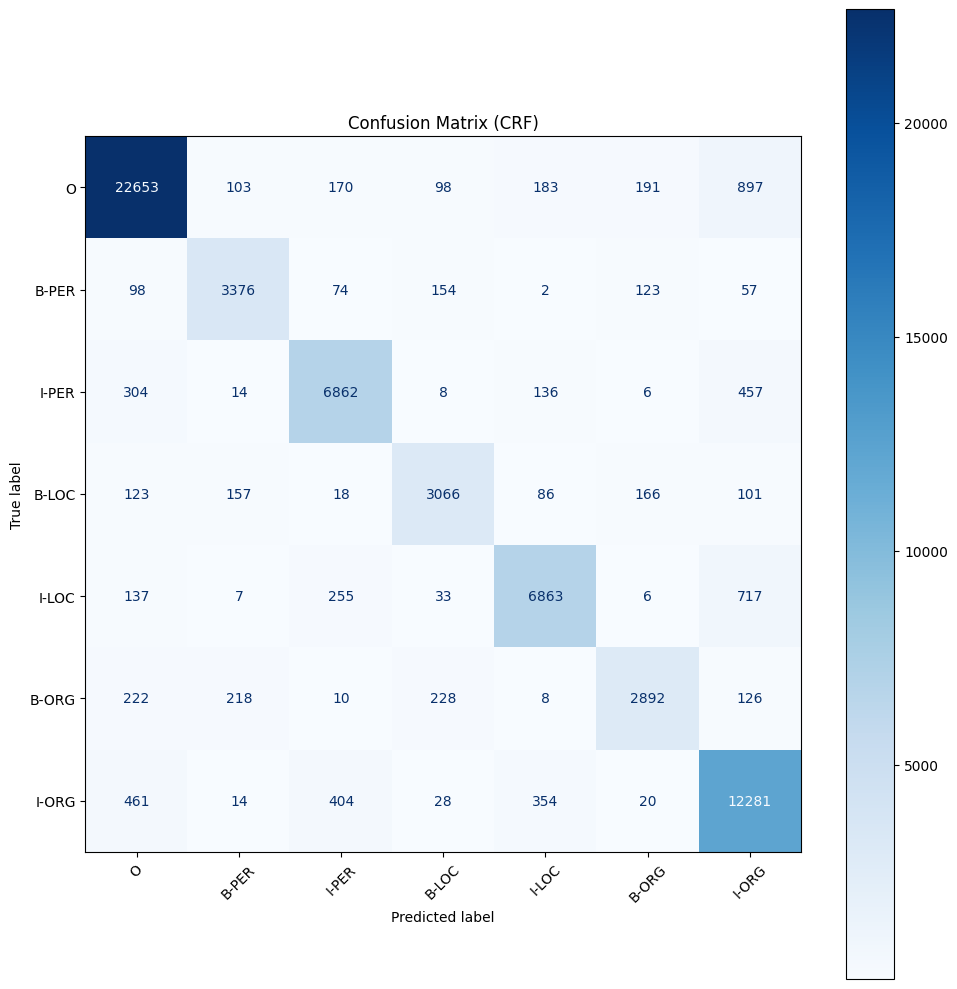

In [9]:
from sklearn_crfsuite import metrics

y_pred = crf.predict(X_test)
accuracy = metrics.flat_accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print(metrics.flat_classification_report(
    y_test, y_pred,
    labels=["O","B-PER","I-PER","B-LOC","I-LOC","B-ORG","I-ORG"],
    digits=4
))

# Flatten nhãn (danh sách các list -> 1 list)
y_test_flat = [label for seq in y_test for label in seq]
y_pred_flat = [label for seq in y_pred for label in seq]

f1_macro = f1_score(y_test_flat, y_pred_flat, average="macro")
print(f"F1-score (macro): {f1_macro:.4f}")

# Danh sách nhãn theo thứ tự mong muốn (nên khớp với classification_report)
labels = ["O", "B-PER", "I-PER", "B-LOC", "I-LOC", "B-ORG", "I-ORG"]

cm = confusion_matrix(y_test_flat, y_pred_flat, labels=labels)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix (CRF)")
plt.tight_layout()
plt.savefig("confusion_matrix_crf.png")
plt.show()
plt.close()

## HMM model

In [10]:
import nltk
from nltk.probability import LidstoneProbDist, WittenBellProbDist, LaplaceProbDist
from nltk.tag.hmm import HiddenMarkovModelTrainer
from collections import Counter

tagger = HiddenMarkovModelTrainer().train_supervised(
    train_sents, estimator=lambda fd, bins: LidstoneProbDist(fd, 0.1, bins)
)

In [11]:
tagger.accuracy(test_sents)

0.8591900503332461

In [12]:
tagger.accuracy(val_sents)

0.8591604123197658

F1-score (macro): 0.8343411653731871
              precision    recall  f1-score   support

       B-LOC       0.86      0.67      0.76      3717
       B-ORG       0.83      0.81      0.82      3704
       B-PER       0.82      0.88      0.85      3884
       I-LOC       0.76      0.84      0.80      8018
       I-ORG       0.83      0.90      0.86     13562
       I-PER       0.85      0.87      0.86      7787
           O       0.93      0.88      0.90     24295

    accuracy                           0.86     64967
   macro avg       0.84      0.83      0.83     64967
weighted avg       0.86      0.86      0.86     64967

              precision    recall  f1-score   support

           O       0.93      0.88      0.90     24295
       B-PER       0.82      0.88      0.85      3884
       I-PER       0.85      0.87      0.86      7787
       B-LOC       0.86      0.67      0.76      3717
       I-LOC       0.76      0.84      0.80      8018
       B-ORG       0.83      0.81      0.

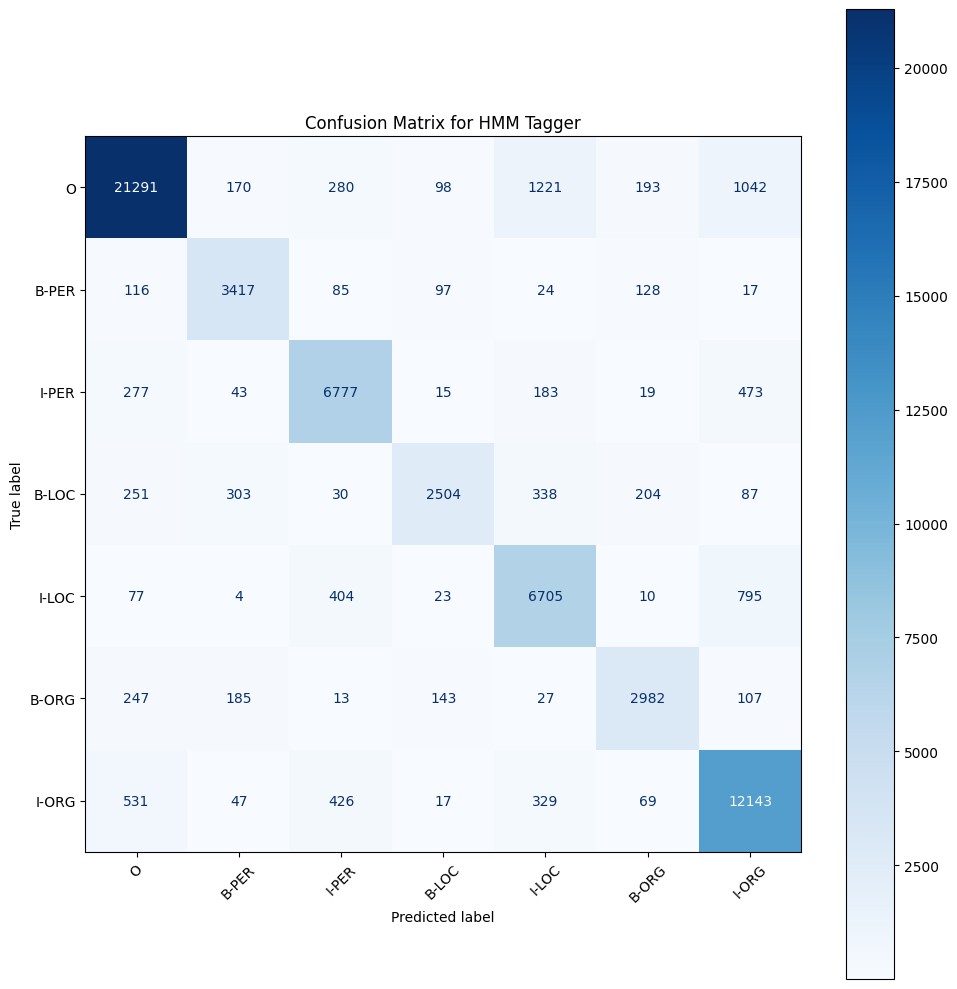

In [13]:
y_true = []
y_pred = []

for sent in test_sents:
    words = [word for word, tag in sent]
    gold_tags = [tag for word, tag in sent]
    pred_tags = tagger.tag(words)
    pred_tags = [tag for word, tag in pred_tags]
    
    y_true.extend(gold_tags)
    y_pred.extend(pred_tags)

from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Tính f1-score macro
f1 = f1_score(y_true, y_pred, average="macro")
print("F1-score (macro):", f1)

# Hoặc in chi tiết từng nhãn
print(classification_report(y_true, y_pred))

# Bạn tự định nghĩa thứ tự nhãn
labels = ["O", "B-PER", "I-PER", "B-LOC", "I-LOC", "B-ORG", "I-ORG"]

# In classification report theo đúng thứ tự labels
print(classification_report(y_true, y_pred, labels=labels))

# Confusion matrix theo đúng thứ tự labels
cm = confusion_matrix(y_true, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix for HMM Tagger")
plt.tight_layout()
plt.savefig("confusion_matrix_hmm.png")
plt.show()
plt.close()

# **Finetune**

In [15]:
import pandas as pd

def load_data(path):
    df = pd.read_excel(path)
    grouped = df.groupby("index")
    sentences = grouped["tokens"].apply(list).tolist()
    labels = grouped["tags"].apply(list).tolist()
    return sentences[1:], labels[1:]  # bỏ dòng đầu nếu cần

# Gộp val + test
sentences, labels = load_data("/kaggle/input/relabel-cs221/val_500_0.xlsx")
sents2, labels2 = load_data("/kaggle/input/relabel-cs221/test_500_0.xlsx")
sentences.extend(sents2)
labels.extend(labels2)

# Lọc các câu chứa NaN
def contains_nan(seq):
    return any(pd.isna(token) for token in seq)

filtered_sentences, filtered_labels = [], []
for tokens, tags in zip(sentences, labels):
    if not contains_nan(tokens) and not contains_nan(tags):
        filtered_sentences.append(tokens)
        filtered_labels.append(tags)

sentences = filtered_sentences
labels = filtered_labels

In [17]:
train_sents_2 = [list(zip(tokens, tags)) for tokens, tags in zip(sentences, labels)]

In [19]:
train_sents = train_sents + train_sents_2

# CRF

In [41]:
def word2features_2(sent, i):
    word = str(sent[i])  # ép kiểu an toàn

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }

    if i > 0:
        word1 = str(sent[i - 1])
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True

    if i < len(sent) - 1:
        word1 = str(sent[i + 1])
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True

    return features


def sent2features_2(sent):
    return [word2features_2(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for _, label in sent]


X_train_2 = [sent2features_2(sent) for sent in sentences]
y_train_2 = labels

In [43]:
id2label = {
    0: "O",
    1: "B-PER",
    2: "I-PER",
    3: "B-ORG",
    4: "I-ORG",
    5: "B-LOC",
    6: "I-LOC"
}
y_train_2 = [[id2label[id] for id in sent] for sent in y_train_2]


In [44]:
X_train_2 = X_train + X_train_2
y_train_2 = y_train + y_train_2

In [45]:
crf = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)


crf.fit(X_train_2, y_train_2)

CRF(algorithm='lbfgs', all_possible_transitions=True, max_iterations=100)

# HMM

In [22]:
print("Training HMM...")
hmm_trainer = HiddenMarkovModelTrainer()
hmm_tagger = hmm_trainer.train_supervised(
    train_sents_2,
    estimator=lambda fd, bins: LidstoneProbDist(fd, 0.1, bins)
)

Training HMM...


[](http://)